In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data_points = []
filename = "test"
with open(f"inputs/{filename}.txt", "r") as f:
    while line := f.readline():
        data_points.append([ float(p) for p in line.rstrip().split(" ")])

data_points = np.array(data_points)

In [3]:

K = 3

total_dist = 0
for i in range(len(data_points)-1):
    total_dist += np.linalg.norm(data_points[i+1] - data_points[i])


t = np.zeros((len(data_points)),dtype=np.float64)

acc_dist = 0
for i in range(len(data_points)-1):
    acc_dist += np.linalg.norm(data_points[i+1] - data_points[i])
    t[i+1] += acc_dist / total_dist

# repeat k to tail and head for intoperate fist and last point, to produce knots
knots = np.concatenate([np.zeros(K), t, np.ones(K)],axis=0)

eps = np.finfo(np.float64).eps

for k_ in range(K+1):
    knots[k_] = (k_+1)*eps
    knots[-(k_+1)] = 1.0 - (k_+1)*eps


In [4]:
from sympy import Piecewise, symbols, IndexedBase, Idx, Matrix, Eq
from scipy.linalg import solve

U = IndexedBase('U', shape=(len(knots),))
i = symbols('i', cls=Idx)
k = symbols('k', cls=Idx)

u = symbols('u')

N_i0 = symbols('N_i0')
N_i1 = symbols('N_i1')

base = Piecewise(
    (1, (u >= U[i]) & (u < U[i+1]) ),
    (0, True),
)
recursive = (u-U[i])/(U[i+k]-U[i])*N_i0 + (U[i+k+1]-u)/(U[i+k+1]-U[i+1])*N_i1

basis = base
for _ in range(K):
    basis = recursive.subs({ N_i0: basis.subs({k:k-1}), N_i1: basis.subs({k:k-1,i:i+1})})

basis = basis.subs({
    U: Matrix(knots),
    k: K,
})

df_basis = basis.diff(u).diff(u)

A = np.zeros((len(data_points)+K-1,len(data_points)+K-1), dtype=np.float64)

for i_ in range(len(data_points)):
    for k_ in range(K):
        A[i_+1,i_+k_] = basis.subs({i: i_+k_, u:knots[i_+K]})

eps = np.finfo(np.float64).eps

for k_ in range(K):
    A[0,k_] = df_basis.subs({i:k_,u:knots[K]+eps})
    A[-1,len(data_points)-1+k_] = df_basis.subs({i:len(data_points)-1+k_,u:knots[-(K+1)]-eps})

x = solve(A, np.concatenate([np.zeros((1,2)),data_points,np.zeros((1,2))],axis=0))
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


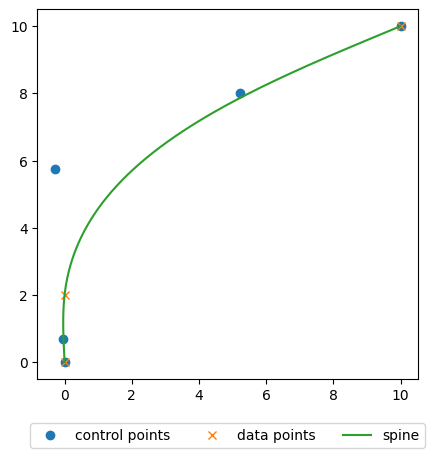

In [5]:

spine = []

fig, ax = plt.subplots()

for seg in range(len(data_points)-1):
    for u_ in np.arange(knots[K+seg], knots[K+seg+1], 0.002):
        r = np.zeros((2,))
        for k_ in range(K+1):
            r += float(basis.evalf(subs={i: seg+k_, u:u_})) * x[seg+k_]
        spine.append(r)

spine = np.asarray(spine)

ax.plot(x[:,0], x[:,1], "o", label="control points")
ax.plot(data_points[:,0], data_points[:,1], "x", label="data points")
ax.plot(spine[:,0], spine[:,1], label="spine")

leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'plots/{filename}.eps', format='eps', bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()

In [6]:
data_points = []
with open(f"outputs/{filename}.txt", "w+") as f:
    f.write(str(K)+"\n")
    f.write(str(len(x))+"\n")
    f.write("\n")
    f.write(" ".join([str(f"{k_:.2f}") for k_ in knots])+"\n")
    f.write("\n")
    for xi in x:
       f.write(" ".join([str(f"{x_:.2f}") for x_ in xi])+"\n")

data_points = np.array(data_points)